In [1844]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import tensorflow as tf
import keras
from keras import layers

In [1845]:
df = pd.read_csv("Concrete_Data_Yeh.csv")
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.00,0.00,0.00,162.00,2.50,1040.00,676.00,28,79.99
1,540.00,0.00,0.00,162.00,2.50,1055.00,676.00,28,61.89
2,332.50,142.50,0.00,228.00,0.00,932.00,594.00,270,40.27
3,332.50,142.50,0.00,228.00,0.00,932.00,594.00,365,41.05
4,198.60,132.40,0.00,192.00,0.00,978.40,825.50,360,44.30


In [1846]:
# Some explanations for the columns:
# cement, slag, flyash, water, superplasticizer, coarseaggregate and fineaggregate are ingredients
# So the number represents how many kg of that ingredient per m^3 (1000L) of concrete

# Age is the age of the concrete in days
# csMPa is the compressive strength in MPa before the concrete fails
# So based on the mixture of ingredients and age of the concrete, it might be possible
# to predict its strength and maybe figure out strong mixtures
# without needing to manually test each potential option

In [1847]:
# There are 25 few duplicates, I'm removing them
# No missing values is good
print(df.duplicated().sum())
df = df.drop_duplicates()

print(df.isna().sum())
print(df.shape)
# This leaves us with 1005 rows of data (from 1030)
# I tried to find if there was more usable data on the internet, but everything I found ended up being the same dataset


25
cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64
(1005, 9)


In [1848]:
# Get the sorted correlation matrix for strength
corr_matrix =df.corr()['csMPa']
corr_matrix.sort_values(ascending=False)

# Slag and flyash are least correlated, water has a slightly negative correlation

csMPa               1.00
cement              0.49
superplasticizer    0.34
age                 0.34
slag                0.10
flyash             -0.08
coarseaggregate    -0.14
fineaggregate      -0.19
water              -0.27
Name: csMPa, dtype: float64

In [1849]:
# Looks like cement, superplasticizer and age have quite a lot of impact
# Slag has a slight impact
# Other ingredients are slightly negatively correlated with the strength
# Water is the highest negative correlated one, about 30%

# I will not remove any columns on the first attempt,
# Later I will check how the model compares if removing the less relevant ones

In [1850]:
df.describe()

# Columns are already numeric, saving me a bit of work

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00
mean,278.63,72.04,55.54,182.08,6.03,974.38,772.69,45.86,35.25
std,104.34,86.17,64.21,21.34,5.92,77.58,80.34,63.73,16.28
min,102.00,0.00,0.00,121.80,0.00,801.00,594.00,1.00,2.33
25%,190.70,0.00,0.00,166.60,0.00,932.00,724.30,7.00,23.52
50%,265.00,20.00,0.00,185.70,6.10,968.00,780.00,28.00,33.80
75%,349.00,142.50,118.30,192.90,10.00,1031.00,822.20,56.00,44.87
max,540.00,359.40,200.10,247.00,32.20,1145.00,992.60,365.00,82.60


<Axes: >

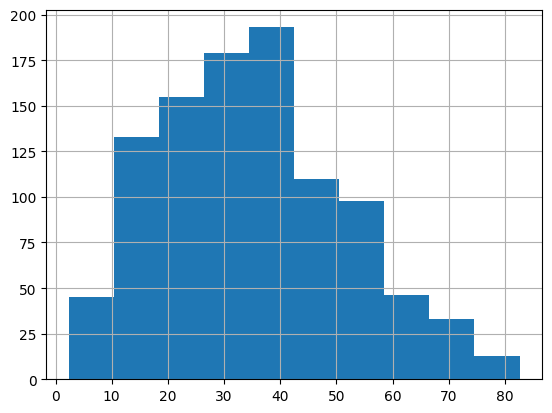

In [1851]:
df["csMPa"].hist()

# Not quite a normal distribution, the lower half of the compressive strength is overrepresented
# Will try to see the impact of equalising it later

In [1852]:
# Setting the feature variables (everything for now)
X = df.drop("csMPa", axis=1)

# Setting the target variable as compressive strength
y = df['csMPa']

<Axes: >

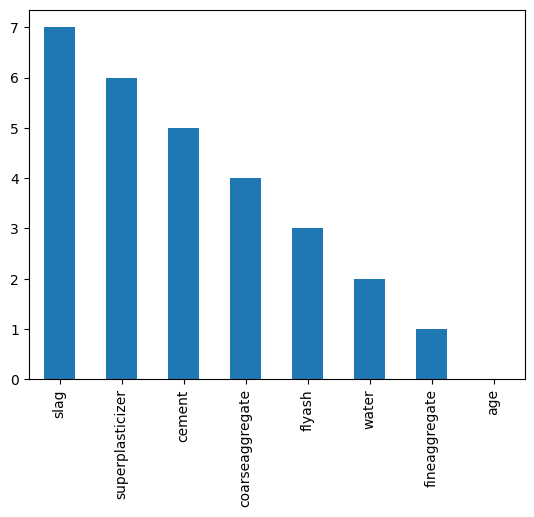

In [1853]:
from skfeature.function.similarity_based import fisher_score

# Testing out the fisher score
ranks = fisher_score.fisher_score(X.values, y.values)

# And show the results in a horizontal bar plot
feat_importances = pd.Series(ranks, X.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar')

# Apparently age is the least important feature? 
# This goes against other observations so far
# I also tried removing the age column, but the model performed a lot worse without it

In [1854]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# Initialising chi2 and SelectKBest
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# Fit the data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# Float formatting
pd.options.display.float_format = '{:.2f}'.format

# Showing the scores
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

# Scores all seem to be decently high, I wouldn't remove any column based on this

,Features,Score
7,age,16820.08
0,cement,12616.33
1,slag,11826.44
2,flyash,8810.73
4,superplasticizer,1332.02
6,fineaggregate,1059.24
5,coarseaggregate,895.12
3,water,445.50


In [1855]:
# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [1856]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Creating the ANN
mc = ModelCheckpoint("best_model.keras", monitor='val_loss', mode='min', save_best_only=True)

# # Creating a list of callbacks
callback_list = [mc]

# Defining the ANN parameters
# Very basic model just for comparison
model = keras.Sequential(
    [
        layers.Dense(16, input_shape=(len(X.columns),), activation="relu"),
        layers.Dense(1)
    ]
)

# Model compiling and summary
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss='mse')
model.summary()

# Fitting the model (training)
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_test, y_test), callbacks=callback_list)

# Returning the best model
best_model = load_model("best_model.keras")


Model: "sequential_262"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1090 (Dense)          (None, 16)                144       
                                                                 
 dense_1091 (Dense)          (None, 1)                 17        
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/500
26/26 [==============================] - 1s 19ms/step - loss: 152610.0625 - val_loss: 32557.3672
Epoch 2/500
26/26 [==============================] - 0s 3ms/step - loss: 8216.8018 - val_loss: 2138.4980
Epoch 3/500
26/26 [==============================] - 0s 3ms/step - loss: 2184.5891 - val_loss: 1495.9625
Epoch 4/500
26/26 [==============================] - 0s 3ms/step - loss: 1459.6416 - val_loss: 1324.2448
Epoch 5/500
26/26 [==============================] - 0s 3ms/step - loss: 1208.5748 - val_loss: 1071.8459
Epoch 6/500
26/26 [==============================] - 0s 2ms/step - loss: 1008.5517 - val_loss: 911.1483
Epoch 7/500
26/26 [==============================] - 0s 3ms/step - loss: 829.0261 - val_loss: 728.9733
Epoch 8/500
26/26 [==============================] - 0s 3ms/step - loss: 645.2532 - val_loss: 571.9620
Epoch 9/500
26/26 [==============================] - 0s 2ms/step - loss: 529.4319 - val_loss: 485.3080
Epoch 10/500
26/26 [==============================] - 0s 3

<Axes: >

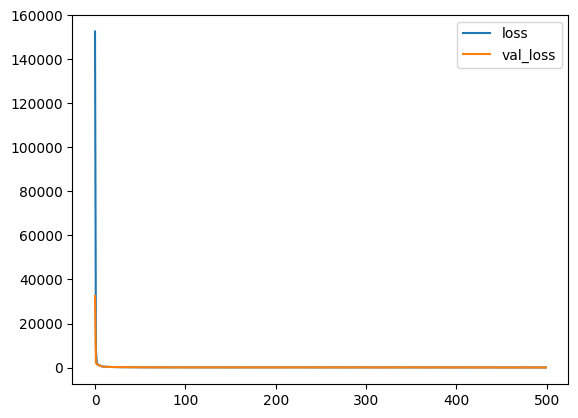

In [1857]:
# Visualising the loss during the training
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# Looking surprisingly good already

In [1858]:
# Evaluation of training and test data
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
69.65611267089844

Train data evaluation:
81.98589324951172


In [1859]:
# Testing predictions
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Real strength'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Real strength', 'Predicted strength']
pred_df

# Predictions seem mostly usable, especially in the range that had more data

7/7 [==============================] - 0s 1ms/step


,Real strength,Predicted strength
0,27.63,23.25
1,14.14,21.68
2,48.67,40.57
3,56.63,46.70
4,28.02,23.04
...,...,...
196,46.68,48.20
197,23.25,25.33
198,40.68,32.40
199,29.72,25.50


<Axes: xlabel='Real strength', ylabel='Predicted strength'>

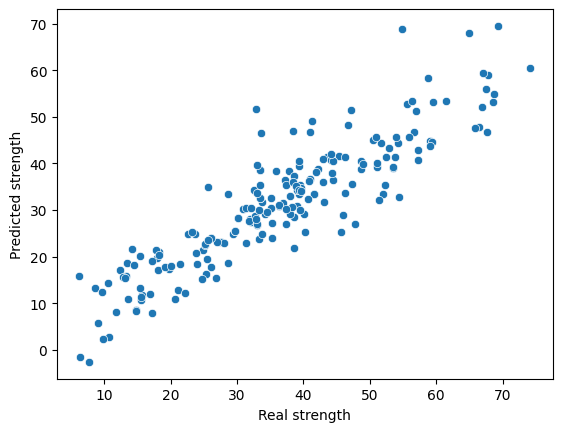

In [1860]:
# Visualising the predictions vs the real values
model_plot = sns.scatterplot(x='Real strength', y='Predicted strength', data=pred_df)
model_plot
# Accuracy seems be lower for higher strengths
# but there is a bit of variation between different training runs

In [1861]:
# Error metrics
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "csMPa")
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "csMPa^2")
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "csMPa")
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

# Results are not bad, but I feel like there should be some room for improvement
# For reference: 
# MAE: 6.77, MSE: 69.66, RMSE: 8.35, R-squared: 0.7, explained variance: 0.81

MAE
6.77 csMPa

MSE
69.66 csMPa^2

RMSE:
8.35 csMPa

R-squared:
0.7

Explained variance score:
0.81


In [1862]:
# Trying out some potential concrete mixture with imaginary values
test_row = {'cement': 450, 
            'slag': 102, 
            'flyash':50 , 
            'water': 50 , 
            'superplasticizer': 4,
            'coarseaggregate': 900, 
            'fineaggregate': 800, 
            'age': 30
}

# Convert to dataframe format
test_row = pd.DataFrame([test_row])

# Model predicts the target variable (strength)
result = model.predict(test_row)[0]

print()
print(f"Estimated concrete strength (csMPa): {round(float(result), 2)}")
print()

# Sadly I don't quite know that much about concrete, so I guess the prediction is okay?
# More interesting to find cases where the model goes haywire with predictions
# And to test out the predictions in real life

1/1 [==============================] - 0s 43ms/step

Estimated concrete strength (csMPa): 54.18



C:\Users\tomco\AppData\Local\Temp\ipykernel_22660\2793850793.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Estimated concrete strength (csMPa): {round(float(result), 2)}")


In [1863]:
# Thoughts after the basic model:
# First I realised that the age is very unevenly distributed, and concrete clearly gets stronger over time
# but there are not many datapoints for cement older than a couple months
# I am going to restrict the data to only one month old, because there's denser data
# And from a usability point of view it would be nicer 
# to test the real life performance of the model more quickly
# and then work on getting good long term predictions after

<Axes: >

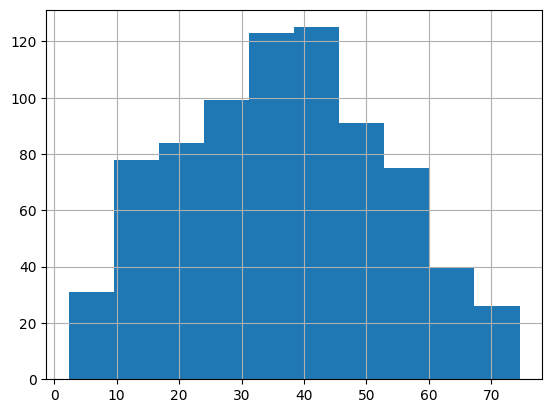

In [1864]:
# I also want to balance the data a bit more
# Sadly I don't see a good way of getting more data, so I remove the overrepresented portion
# I could generate fake data, but I feel like that is risky without good knowledge about concrete

# First copying the dataframe
# Then defining bins based on the range of compression strength values
df3 = df.copy()
bins = np.linspace(df3["csMPa"].values.min(), df3["csMPa"].values.max(), 11)
labels = [1,2,3,4,5,6,7,8,9,10]

# The new column represents which bin each of the rows falls into
df3['binned'] = pd.cut(df3['csMPa'], bins=bins, labels=labels)

# I decide that the bins with more than 120 counts should be reduced
counts = df3['binned'].value_counts()
high_count_bins = counts[counts > 120].index

# I check if a row's bin is in the list of high count bins to collect the indices
for bin in high_count_bins:
    indices = df3['binned'][df3['binned'] == bin].index

    # Then I randomly pick some indices that will be removed from the bins
    # I drop about 1/3rd of them
    dropped_indices = np.random.choice(indices, size=round(len(indices) / 3), replace=False)
    df3.drop(dropped_indices, inplace=True)

    # And I decide to drop the last bin as well, since it might be too much of an outlier
    df3.drop(df3['binned'][df3['binned'] == 10].index, inplace=True)

# Plotting the new histogram of the csMPa column values
df3['csMPa'].hist()

# Not the best solution, but good enough for testing purposes I suppose
# If there would be an easy way to balance out the dataset to follow a normal distribution
# I would be interested in knowing about it

In [1865]:
# Excluding rows where the cement is older than 60 days
df2 = df3.loc[(df3['age'] <= 60)]

# Get the sorted correlation matrix for strength
corr_matrix =df2.corr()['csMPa']
corr_matrix.sort_values(ascending=False)

# Correlations didn't change much, which is good
# Obviously correlation with age is a bit stronger now

csMPa               1.00
binned              0.99
age                 0.58
cement              0.54
superplasticizer    0.45
slag                0.07
flyash             -0.02
fineaggregate      -0.15
coarseaggregate    -0.20
water              -0.40
Name: csMPa, dtype: float64

In [1866]:
# Setting the feature variables
X = df2.drop(["csMPa", "binned"], axis=1)

# Alternetively: dropping the less correlated features (ended up not helping)
# X = df2.drop(["csMPa", "binned", "slag", "flyash"], axis=1)

# Setting the target variable as compressive strength
y = df2['csMPa']

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=5)

Model: "sequential_263"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_221 (B  (None, 8)                 32        
 atchNormalization)                                              
                                                                 
 dense_1092 (Dense)          (None, 64)                576       
                                                                 
 dense_1093 (Dense)          (None, 16)                1040      
                                                                 
 dense_1094 (Dense)          (None, 16)                272       
                                                                 
 dense_1095 (Dense)          (None, 128)               2176      
                                                                 
 dense_1096 (Dense)          (None, 1)                 129       
                                                    

Epoch 1/500
16/16 [==============================] - 1s 12ms/step - loss: 1377.5619 - val_loss: 544.3412
Epoch 2/500
16/16 [==============================] - 0s 3ms/step - loss: 981.1980 - val_loss: 3011.5962
Epoch 3/500
16/16 [==============================] - 0s 3ms/step - loss: 314.1016 - val_loss: 9448.1084
Epoch 4/500
16/16 [==============================] - 0s 3ms/step - loss: 145.6510 - val_loss: 2549.8223
Epoch 5/500
16/16 [==============================] - 0s 3ms/step - loss: 126.1718 - val_loss: 1417.5168
Epoch 6/500
16/16 [==============================] - 0s 3ms/step - loss: 115.8760 - val_loss: 718.7119
Epoch 7/500
16/16 [==============================] - 0s 10ms/step - loss: 119.1499 - val_loss: 380.2029
Epoch 8/500
16/16 [==============================] - 0s 5ms/step - loss: 109.7560 - val_loss: 335.8662
Epoch 9/500
16/16 [==============================] - 0s 5ms/step - loss: 105.6658 - val_loss: 217.3690
Epoch 10/500
16/16 [==============================] - 0s 5ms/step 

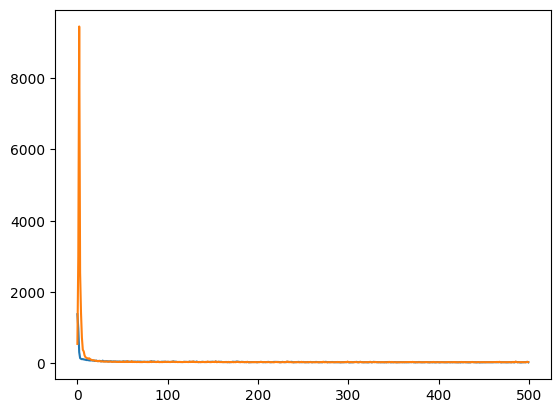

In [1867]:
# Creating the ANN
mc = ModelCheckpoint("best_model.keras", monitor='val_loss', mode='min', save_best_only=True)

# # Creating a list of callbacks
callback_list = [mc]

# Defining the ANN parameters
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ]
)

# Model compiling and summary
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss='mse')
model.summary()

# Fitting the model (training)
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_test, y_test), callbacks=callback_list)

# return the best model

best_model = load_model("best_model.keras")

# Visualising the loss during the training
plt.plot(pd.DataFrame(model.history.history))

In [1868]:
# Using the best model from the model checkpoint
model = best_model

# Evaluation of training and test data
print("Test data evaluation:")
print(f"{model.evaluate(X_test, y_test, verbose=0)}")

print("\nTrain data evaluation:")
print(f"{model.evaluate(X_train, y_train, verbose=0)}")

# Test predictions
test_predictions = model.predict(X_test)
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))

# Error metrics
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "csMPa")
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "csMPa^2")
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "csMPa")
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

# This is a result after trying to optimise the model:
# MAE: 3.7, MSE: 22.92, RMSE: 4.79, R-squared: 0.92, explained variance: 0.92
# Test and train data evaluation are proportionally further apart than before but similar absolute difference
# First model: test: 69.7 train: 82 
# New model: test: 27.6, train: 17.1
# But I don't know if it is really worse or similarly good

Test data evaluation:
27.5539493560791

Train data evaluation:
17.112852096557617
4/4 [==============================] - 0s 1ms/step
MAE
3.7 csMPa

MSE
22.92 csMPa^2

RMSE:
4.79 csMPa

R-squared:
0.92

Explained variance score:
0.92


<Axes: xlabel='Real strength', ylabel='Predicted strength'>

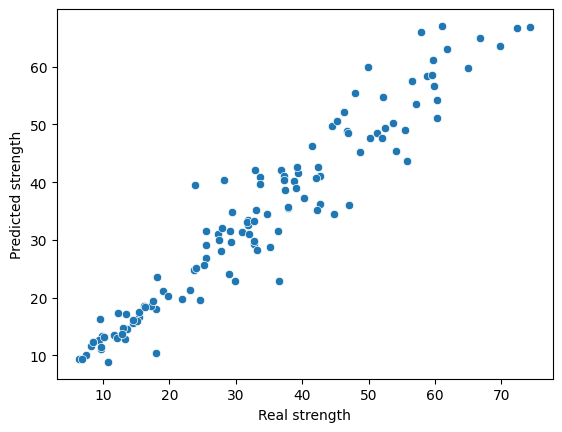

In [1869]:
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Real strength'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Real strength', 'Predicted strength']

# Plotting predictions
sns.scatterplot(x='Real strength', y='Predicted strength', data=pred_df)

# The graph looks quite linear, I personally think this seems pretty good
# On the upper end I would be somewhat cautious without more data
# But I don't see many big outliers here

In [1870]:
# Testing predictions
pred_df

# I think it does much better than before
# low strengths are predicted to be low and high strengths to be high
# Basically it confirms what we see in the scatterplot, the points follow the diagonal more closely

,Real strength,Predicted strength
0,9.74,11.17
1,13.62,14.62
2,50.24,47.57
3,29.22,29.57
4,7.51,10.05
...,...,...
119,59.80,56.65
120,39.05,39.05
121,52.20,54.68
122,8.54,12.25


In [1871]:
# Predictions with imaginary values for improved model
test_row = {'cement': 450, 
            'slag': 102, 
            'flyash':50 , 
            'water': 50 , 
            'superplasticizer': 4,
            'coarseaggregate': 900, 
            'fineaggregate': 800, 
            'age': 30
}

# Convert to dataframe format
test_row = pd.DataFrame([test_row])

# Model predicts the target variable (strength)
result = model.predict(test_row)[0]

print()
print(f"Estimated concrete strength (csMPa): {round(float(result), 2)}")
print()

# This model seems to be more conservative based on the tested predictions, which I think is probably a good thing
# You don't want to overestimate concrete strength and have a building collapse because the AI said it would be fine
# Cement obviously has a strong impact on results in both directions
# More slag, flyash, fineaggregate moderately increase the predictions, but lowering it does not do as much
# Superplasticizer seems to slightly lower the results
# Coarseaggregate lowers strength if it's too much or too little
# Age is definitely the problematic factor, because the dataset mostly tested young concrete
# In reality concrete structures are made to last many years
# And the strength might increase considerably in the first year, but after that probably slows down
# The model thinks that 10-year old cement would be near-indestructible because it assumes the same rate of hardening as in the first few months
# If strength after about 1 month is a good indicator of how strong it will be in general
# Then it shouldn't be a problem
# But if there is a lot of variation in real life (e.g. strength could drop off or increase considerably after >1 year)
# then it would be good to make a new dataset/model for long term predictions

1/1 [==============================] - 0s 101ms/step

Estimated concrete strength (csMPa): 36.81



C:\Users\tomco\AppData\Local\Temp\ipykernel_22660\1733448440.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Estimated concrete strength (csMPa): {round(float(result), 2)}")


In [1872]:
# I tried the following things to improve the model, but didn't seem to work:
# - dropping columns, such as flyash and slag (since the correlations with compressive strength were low)
# - best performance was by not dropping any columns
# - I tried different losses for model.compile, inter alia msle, mae and huber
# - adding dropout layers, they seemed to just make it slightly worse in every case
# - increasing and lowering learning rate, or the regulariser parameter
# - adding a lot of layers and changing their sizes

# Things that I did that worked:
# - Balancing the dataset to more closely follow a Gaussian distribution
# - Removing rows with age-column above 60 days (basically outliers)
# - Using l1-regulariser with l1=01
# - Using batch normaliser
# - Changing the layers, I ended up with a layer of 128 at the end, it seems to keep loss more consistent

# Observations:
# If I understand correctly, a solid model should usually have a close test and train evaluation
# Some things I changed seemed to grow or narrow the difference without changing R2-score much
# But often it seemed like it was randomly fluctuating and I couldn't get it to be consistently good alongside high R2-score
# Loss-curve looks really good, even for the super basic model, so it was already usable data from the start
# I basically just squeezed out around 10% of performance that was left on the table

# Error metrics:
# MAE is the mean absolute error, so basically how off the model is on average
# Since the range of concrete strength is 2 - 82, MAE of around 4 is pretty low
# MSE is the mean squared error, which punishes large errors more
# RMSE is basically the MAE (in the same scale as the predicted value) but with an extra penalty based on the MSE
# R-squared demonstrates how well the model predicts on a scale from 0 (unusable model) to 1 (model predicts perfectly)
# explained variance is similar to R-squared but takes the mean error into account

# Ideas for optimisation:
# Studying concrete hardening over time and evaluating if there would be a use for a model that can handle longer timeframes
# Of course a higher data volume, with more data on the higher end
# Including other relevant variables that might be missing in this dataset

In [ ]:
# Thoughts:
# I think this model is quite useful, although there are a few limitations
# It works best in the range of the data it was trained with
# So unusual concrete mixtures or a large age would likely output bad predictions

# Useful applications I can imagine:
# -Someone without deep chemical knowledge trying to aim for a certain target strength (e.g. 70 csMPa)
#  Who can't afford to waste money and time with trial and error
# -A scenario where some ingredients are limited or unavailable and trying to make the best with what they have
# -Coming up with cost-efficient mixtures

# In my opinion, provided usable data, linear regression as a whole is great to basically
# turn guesses into educated guesses, even without the "educated"-part
# E.g. I don't know anything about concrete and could not guess the strength
# But now I have a tool that, within the effective ranges, let's me have a decent chance at being within 10% of the actual concrete strength
# The same way someone could plan and estimate their electricity expenses before building a house
# Or estimate how much they could sell their home for and if there would be something worth changing/renovating to increase profit
# There are lots more useful scenarios I can come up with, but the bottom line is that it can save time and money 
# to get an idea about something in advance
